In [1]:
import numpy as np

nx = 8
ny = 5
maxedge = 0.2;
minedge = 0.025;
# 矩形区域的边界
BDY = np.array([[-.5 * nx, -.5 * ny], [.5 * nx, .5 * ny]]) / 100
x = np.linspace(BDY[0,0], BDY[1,0], nx+1)
y = np.linspace(BDY[0,1], BDY[1,1], ny+1)
xn, yn = np.meshgrid(x, y)
# 网格节点的密度值
dN = np.sin(xn/BDY[1,0]*6*np.pi) * np.cos(yn/BDY[1,0]*6*np.pi) + 0.5

In [2]:
def redis_points(C, d1, d2):
    """
    重新分布材质边界上的点
    """
    C = C.T
    C1 = C.copy()
    CL = np.sqrt(np.sum(np.diff(C1, axis=0)**2, axis=1))
    
    # 调整距离过小的点
    i = 0
    while i < len(C1) - 1:
        if CL[i] < d1:
            C1[i] = [0, 0]
            C1[i + 1] = 0.5 * (C[i] + C[i + 1])
        i += 1

    # 删除所有被设置为[0,0]的点
    C1 = C1[~np.all(C1 == [0, 0], axis=1)]

    # 重新计算点间距离
    CL2 = np.sqrt(np.sum(np.diff(C1, axis=0)**2, axis=1))
    Cmid = []
    
    # 添加需要的点以满足距离要求
    for i in range(len(C1) - 1):
        if CL2[i] > d2:
            Cmid.append(0.5 * (C1[i] + C1[i + 1]))

    # 如果有中间点，将其添加到点集中
    if Cmid:
        Cmid = np.array(Cmid)
        C1 = np.vstack([C1, Cmid])
        C1 = np.unique(C1, axis=0)

    return C1

In [3]:
def generate_mesh(xn, yn, dN, maxedge, minedge, BDY, maxiter):
    # 根据您的代码，修改每一行偶数行的x坐标
    x = xn.copy()
    x[1::2, :] += 0.005 

    # 创建初始图案 pi 数组，节点在设计区域中均匀分布
    pi = np.column_stack((x.flatten('F'), yn.flatten('F')))

    # 使用matplotlib生成等高线，找出零水平集
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots()
    CS = ax.contour(xn, yn, dN, levels=[0])

    # 每个等高线段之前会有一列包含两个值，
    # 第一个值是等高线的级别（本例中是 0，因为是零水平集），第二个值是该等高线段包含的顶点个数
    # 初始化C数组
    C = np.empty((2, 0))

    # 提取每个路径的坐标点
    for path in CS.collections[0].get_paths():
        vertices = path.vertices.T  # 转置后的形状是(2, N)，其中N是顶点数量
        segment_info = np.array([[0], [vertices.shape[1]]])  # 调整为形状(2, 1)
        vertices_with_info = np.hstack((segment_info, vertices))  # 前置信息
        C = np.hstack((C, vertices_with_info))  # 横向堆叠

    # 确保C的形状符合预期
    if C.shape[1] > 40:
        # 如果顶点数量大于40，可以进行插值或选择前40个点
        C = C[:, :40]

    C1 = np.empty((0, 2))  # 初始化空数组，用于存储调整后的点
    
    dump = np.where((C[0,:] == 0) & (C[1,:] >= 2))[0]
    
    # 调用 RedisPoints 函数
    for i in range(len(dump) - 1):
        segment = C[:, dump[i] + 1:dump[i + 1]]  # 根据 dump 索引切片 C
        adjusted_points = redis_points(segment, 0.004, 0.01)  # 调整点位置
        C1 = np.hstack([C1, adjusted_points.T])

    last_segment = C[:, dump[-1]+1]
    final_adjusted_points = redis_points(last_segment, 0.004, 0.01)
    C = np.hstack([C1, final_adjusted_points.T])
    
    # 计算顶点节点与其在实心-空心界面上最近点之间的距离 d
    d = np.zeros(pi.shape[0])
    for i in range(pi.shape[0]):
        distances = np.sqrt(np.sum((pi[i] - C.T[:, 1:])**2, axis=1))
        d[i] = np.min(distances)

    return None

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 0 and the array at index 1 has size 2

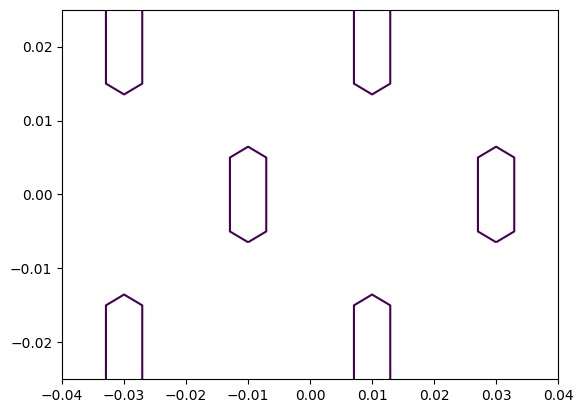

In [4]:
for iterNum in range(1):
    generate_mesh(xn=xn, yn=yn, dN=dN, maxedge=maxedge, minedge=minedge, BDY=BDY, maxiter=80)